In [77]:
import os 
import pandas as pd
import seaborn as sns
import numpy as np

In [78]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings

In [79]:
df = pd.read_csv('C:/Users/ky_moon/Desktop/bigcon/data_with_residual.csv')
df = df.drop('Unnamed: 0', axis=1)
test_data = df.iloc[210:]
df = df.iloc[:210]
df.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year,fitted,residual
0,2015-12-28,18.827252,48.332993,42.723972,13.288000,111.280,114.305,2015,13.080134,0.207866
1,2016-01-04,15.008106,47.931973,29.411020,12.855000,109.814,112.292,2016,12.971560,-0.116560
2,2016-01-11,15.327347,47.514286,32.301088,12.876667,108.948,111.120,2016,13.031678,-0.155012
3,2016-01-18,15.330000,47.386531,38.159864,13.386667,109.228,111.312,2016,13.099202,0.287464
4,2016-01-25,19.857103,47.281633,40.924449,12.645000,109.566,111.866,2016,12.996417,-0.351417


#### 잔차의 이동평균 구하기 (시점의 정보를 반영하기 위해)

In [112]:
res = df[['DATE', 'residual']]
MA4 = res.rolling(window=4, min_periods=1).mean()

df['MA'] = MA4

In [113]:
df.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year,fitted,residual,MA
0,2015-12-28,18.827252,48.332993,42.723972,13.288000,111.280,114.305,2015,13.080134,0.207866,0.207866
1,2016-01-04,15.008106,47.931973,29.411020,12.855000,109.814,112.292,2016,12.971560,-0.116560,0.045653
2,2016-01-11,15.327347,47.514286,32.301088,12.876667,108.948,111.120,2016,13.031678,-0.155012,-0.021235
3,2016-01-18,15.330000,47.386531,38.159864,13.386667,109.228,111.312,2016,13.099202,0.287464,0.055940
4,2016-01-25,19.857103,47.281633,40.924449,12.645000,109.566,111.866,2016,12.996417,-0.351417,-0.083881


<AxesSubplot:ylabel='residual'>

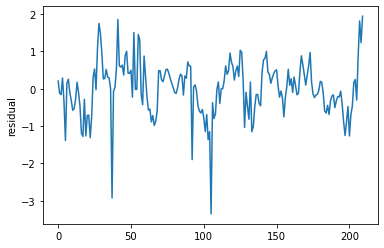

In [80]:
import seaborn as sns

sns.lineplot(data=df['residual'])

In [114]:
df1 = df[['DATE', 'WIND_SPEED', 'AIR_TEMP', 'Broad', 'MA', 'residual']]

In [115]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        210 non-null    object 
 1   WIND_SPEED  210 non-null    float64
 2   AIR_TEMP    210 non-null    float64
 3   Broad       210 non-null    float64
 4   MA          210 non-null    float64
 5   residual    210 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.0+ KB


In [117]:
y = df1['residual']
X = df1[['WIND_SPEED', 'AIR_TEMP', 'Broad', 'MA']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [118]:
xgb_model = xgb.XGBRegressor(n_estimators=10, learning_rate=0.08, gamma=0, subsample=0.75,
                             colsample_bytree=1, max_depth=7)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [119]:
predictions = xgb_model.predict(X_test)
predictions

array([ 0.05787306,  0.9252817 , -0.21426862,  0.4418882 ,  0.2449503 ,
        0.41815293,  0.37767226,  0.13672131,  0.12208883, -0.08819327,
       -0.08855504, -0.1893893 , -0.28361642,  0.1854006 ,  0.49145034,
        0.11599747,  0.5976257 ,  0.36983234,  0.42367777, -0.31452376,
        0.02941563,  0.3038908 ,  0.46473616,  0.20092687,  0.82755804,
        0.3526077 ,  0.2790186 , -0.32036304,  0.52099013,  0.34338844,
        0.66879475,  0.18263905,  0.36586916, -0.2435723 ,  0.41815293,
        0.03317634, -0.27043736,  0.3944032 , -0.16794209,  0.346117  ,
        0.08979429, -0.15001199], dtype=float32)

In [120]:
r_sq = xgb_model.score(X_train, y_train)
print(r_sq)
print(explained_variance_score(predictions,y_test))

0.49580784390872856
-2.374460834659015


In [121]:
compare = pd.DataFrame(y_test)
compare['predicted'] = list(predictions)
compare['error'] = compare['residual'] - compare['predicted']

In [122]:
compare.head()

,residual,predicted,error
133,-1.149693,0.057873,-1.207566
207,1.818224,0.925282,0.892942
203,0.165596,-0.214269,0.379865
167,0.884101,0.441888,0.442213
92,-1.896850,0.244950,-2.141800


In [111]:
sse = 0
for err in compare['error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)  # without 'MA'

0.415618416372589


In [123]:
sse = 0
for err in compare['error']:
    se = err**2
    sse += se
mse = sse / compare.shape[0]
print(mse)  # with 'MA'

0.356341631127592
